<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%ED%8F%AC%EB%94%94%EB%B8%94%EB%A1%9D_%EA%B5%AC%EC%A1%B0_%EC%B6%94%EC%B6%9C_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

포디블록 구조 추출 AI 경진대회

https://dacon.io/competitions/official/236046/overview/description

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/open.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/TRAIN_27994.jpg   
  inflating: train/TRAIN_27995.jpg   
  inflating: train/TRAIN_27996.jpg   
  inflating: train/TRAIN_27997.jpg   
  inflating: train/TRAIN_27998.jpg   
  inflating: train/TRAIN_27999.jpg   
  inflating: train/TRAIN_28000.jpg   
  inflating: train/TRAIN_28001.jpg   
  inflating: train/TRAIN_28002.jpg   
  inflating: train/TRAIN_28003.jpg   
  inflating: train/TRAIN_28004.jpg   
  inflating: train/TRAIN_28005.jpg   
  inflating: train/TRAIN_28006.jpg   
  inflating: train/TRAIN_28007.jpg   
  inflating: train/TRAIN_28008.jpg   
  inflating: train/TRAIN_28009.jpg   
  inflating: train/TRAIN_28010.jpg   
  inflating: train/TRAIN_28011.jpg   
  inflating: train/TRAIN_28012.jpg   
  inflating: train/TRAIN_28013.jpg   
  inflating: train/TRAIN_28014.jpg   
  inflating: train/TRAIN_28015.jpg   
  inflating: train/TRAIN_28016.jpg   
  inflating: train/TRAIN_28017.jpg   
  inflating: train/TRAIN_28018.jpg   
  inflating: t

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32994 entries, 0 to 32993
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32994 non-null  object
 1   img_path  32994 non-null  object
 2   A         32994 non-null  int64 
 3   B         32994 non-null  int64 
 4   C         32994 non-null  int64 
 5   D         32994 non-null  int64 
 6   E         32994 non-null  int64 
 7   F         32994 non-null  int64 
 8   G         32994 non-null  int64 
 9   H         32994 non-null  int64 
 10  I         32994 non-null  int64 
 11  J         32994 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.0+ MB


In [5]:
train_path = sorted(glob.glob('/content/train/*.jpg'))
test_path = sorted(glob.glob('/content/test/*.jpg'))
train['img_path'] = train_path
test['img_path'] = test_path

In [ ]:
train.head()

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,/content/train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,/content/train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,/content/train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,/content/train/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,/content/train/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0


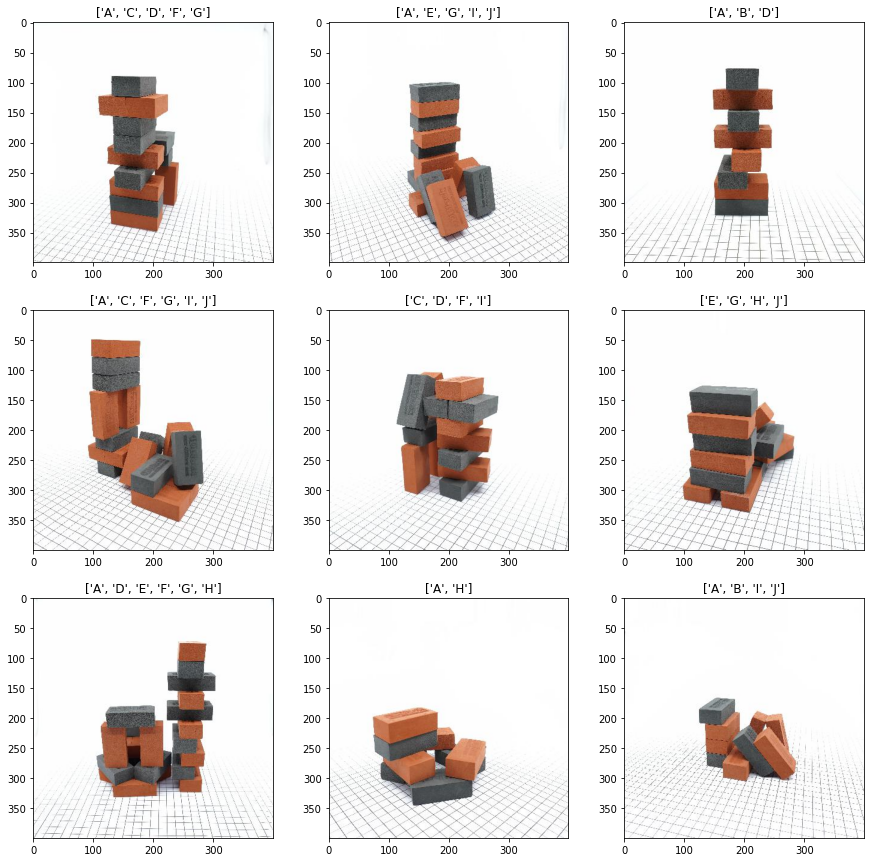

In [ ]:
se_img = np.arange(len(train['img_path']))
np.random.shuffle(se_img)
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = cv2.imread(train.loc[se_img[i]]['img_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    tt = []
    for j in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
        if train.loc[se_img[i]][j]:
            tt.append(j)
    plt.title(tt)
plt.show()

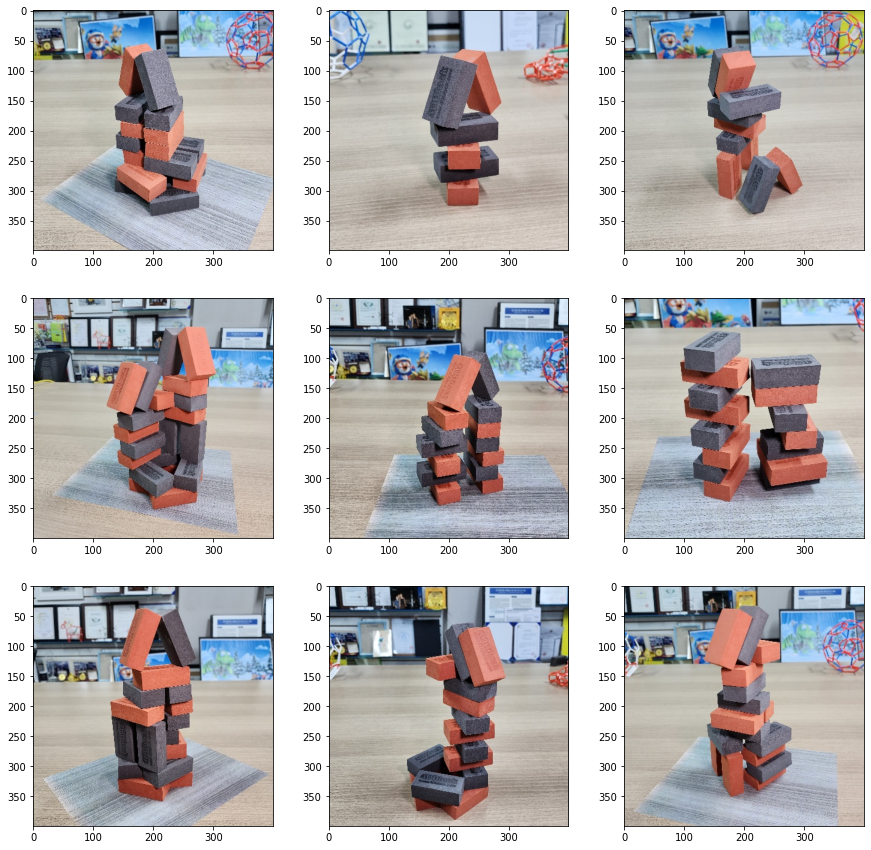

In [6]:
se_img = np.arange(len(test['img_path']))
np.random.shuffle(se_img)
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = cv2.imread(test.loc[se_img[i]]['img_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

In [7]:
argument = A.Compose([A.RandomBrightnessContrast(p=0.5),
                    #   A.RandomResizedCrop(height=0.1, width=0.1, p=0.5),
                      A.HorizontalFlip(p=0.5),
                      A.Rotate(limit=10, p=0.5)])

class data_generater(tf.keras.utils.Sequence):
    def __init__(self, path, label=None, img_size=(400,400), batch_size=32, shuffle=False, argument=None):
        self.path = path
        self.label = label
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.argument = argument

        self.one_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.path) / self.batch_size))

    def __getitem__(self, index):
        path_sel = self.path[self.data_idx[index * self.batch_size : (index + 1) * self.batch_size]]
        if self.label is not None:
            label_sel = self.label[self.data_idx[index * self.batch_size : (index + 1) * self.batch_size]]

        images = np.zeros((len(path_sel), img_size[0], img_size[1], 3), dtype=np.float32)

        for i, path in enumerate(path_sel):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            if self.argument is not None:
                img = self.argument(image=img)['image']
            img = img / 255
            images[i] = img

        if self.label is not None:
            return images, label_sel
        else :
            return images

    def one_epoch_end(self):
        self.data_idx = np.arange(len(self.path))
        if self.shuffle:
            np.random.shuffle(self.data_idx)

In [8]:
train_df, val_df = train_test_split(train, test_size=0.1 ,shuffle=True, random_state=42)
print(train_df.shape, val_df.shape)
img_size = (224,224)
train_ds = data_generater(train_df['img_path'].values, train_df.iloc[:,2:].values, img_size = img_size, shuffle=True, argument=argument)
val_ds = data_generater(val_df['img_path'].values, val_df.iloc[:,2:].values, img_size = img_size, shuffle=True)

(29694, 12) (3300, 12)


In [9]:
def custom_acc(y_true, y_pre):
    y_pre = y_pre > 0.5
    y_pre = tf.cast(y_pre, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    return y_true == y_pre

In [ ]:
img_size = (400,400)
def make_model():
    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(256, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outouts = layers.Dense(10, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outouts)
    return model

In [ ]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 400, 400, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 198, 198, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 198, 198, 64)     256   

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10)

Epoch 1/10
928/928 [==============================] - 245s 263ms/step - loss: 7393204.0000 - accuracy: 0.1600 - val_loss: 4433123.0000 - val_accuracy: 0.4494
Epoch 2/10
928/928 [==============================] - 243s 262ms/step - loss: 3332842.0000 - accuracy: 0.2170 - val_loss: 2998824.2500 - val_accuracy: 0.4494
Epoch 3/10
928/928 [==============================] - 243s 262ms/step - loss: 1694127.1250 - accuracy: 0.2895 - val_loss: 1164197.0000 - val_accuracy: 0.4494
Epoch 4/10
928/928 [==============================] - 244s 262ms/step - loss: 728900.6250 - accuracy: 0.3330 - val_loss: 396161.1562 - val_accuracy: 0.4494
Epoch 5/10
928/928 [==============================] - 244s 263ms/step - loss: 157592.3750 - accuracy: 0.2479 - val_loss: 13.3366 - val_accuracy: 0.4494
Epoch 6/10
928/928 [==============================] - 244s 262ms/step - loss: 1.0876 - accuracy: 0.0995 - val_loss: 6.1735 - val_accuracy: 0.0367
Epoch 7/10
928/928 [==============================] - 244s 263ms/step - 

In [172]:
prepro = tf.keras.applications.resnet50.preprocess_input
basemodel = tf.keras.applications.ResNet50(include_top=False)
# basemodel.trainable = False

In [173]:
def make_model():
    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = prepro(inputs)
    x = basemodel(x)

    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outouts = layers.Dense(10, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outouts)
    return model

In [174]:
model = make_model()
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [175]:
lr_re = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[custom_acc])

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10, callbacks=[lr_re])

Epoch 1/10
928/928 [==============================] - 340s 361ms/step - loss: 0.3005 - custom_acc: 0.8598 - val_loss: 0.7657 - val_custom_acc: 0.5260 - lr: 3.0000e-04
Epoch 2/10
928/928 [==============================] - ETA: 0s - loss: 0.1244 - custom_acc: 0.9517
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
928/928 [==============================] - 334s 360ms/step - loss: 0.1244 - custom_acc: 0.9517 - val_loss: 2.2941 - val_custom_acc: 0.5383 - lr: 3.0000e-04
Epoch 3/10
928/928 [==============================] - ETA: 0s - loss: 0.0630 - custom_acc: 0.9754
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
928/928 [==============================] - 334s 360ms/step - loss: 0.0630 - custom_acc: 0.9754 - val_loss: 1.9677 - val_custom_acc: 0.5220 - lr: 1.5000e-04
Epoch 4/10
821/928 [=========================>....] - ETA: 37s - loss: 0.0373 - custom_acc: 0.9853

In [10]:
prepro = tf.keras.applications.mobilenet_v2.preprocess_input
basemodel = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3))

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
def make_model():
    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = prepro(inputs)
    x = basemodel(x)

    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outouts = layers.Dense(10, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outouts)
    return model

In [12]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [13]:
lr_re = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[custom_acc])

In [14]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10, callbacks=[lr_re])

Epoch 1/10
928/928 [==============================] - 227s 230ms/step - loss: 0.3183 - custom_acc: 0.8474 - val_loss: 5.6642 - val_custom_acc: 0.5593 - lr: 3.0000e-04
Epoch 2/10
928/928 [==============================] - ETA: 0s - loss: 0.1377 - custom_acc: 0.9456
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
928/928 [==============================] - 212s 229ms/step - loss: 0.1377 - custom_acc: 0.9456 - val_loss: 7.5855 - val_custom_acc: 0.5491 - lr: 3.0000e-04
Epoch 3/10
928/928 [==============================] - ETA: 0s - loss: 0.0743 - custom_acc: 0.9707
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
928/928 [==============================] - 212s 228ms/step - loss: 0.0743 - custom_acc: 0.9707 - val_loss: 7.5131 - val_custom_acc: 0.5641 - lr: 1.5000e-04
Epoch 4/10
928/928 [==============================] - 213s 229ms/step - loss: 0.0468 - custom_acc: 0.9818 - val_loss: 4.4957 - val_custom_acc: 0.5855 - lr: 7.5000e-05
Epoch 

In [73]:
prepro = tf.keras.applications.efficientnet_v2.preprocess_input
basemodel = tf.keras.applications.EfficientNetV2B0(include_top=False, input_shape=(224,224,3))

24274472/24274472 [==============================] - 2s 0us/step


In [74]:
def make_model():
    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = prepro(inputs)
    x = basemodel(x)

    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outouts = layers.Dense(10, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outouts)
    return model

In [85]:
model = make_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 2048)              2623488   
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 1024)              2098

In [86]:
lr_re = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [87]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10, callbacks=[lr_re])

Epoch 1/10
928/928 [==============================] - 200s 205ms/step - loss: 0.0417 - accuracy: 0.3158 - val_loss: 0.3966 - val_accuracy: 0.1927 - lr: 3.0000e-04
Epoch 2/10
928/928 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.3557
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
928/928 [==============================] - 189s 204ms/step - loss: 0.0242 - accuracy: 0.3557 - val_loss: 1.4941 - val_accuracy: 0.1042 - lr: 3.0000e-04
Epoch 3/10
928/928 [==============================] - 187s 202ms/step - loss: 0.0154 - accuracy: 0.3149 - val_loss: 0.0457 - val_accuracy: 0.3212 - lr: 1.5000e-04
Epoch 4/10
928/928 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.3024
Epoch 4: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
928/928 [==============================] - 189s 203ms/step - loss: 0.0119 - accuracy: 0.3024 - val_loss: 0.2613 - val_accuracy: 0.2482 - lr: 1.5000e-04
Epoch 5/10
928/928 [======

In [89]:
prepro = tf.keras.applications.inception_v3.preprocess_input
basemodel = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3))

87910968/87910968 [==============================] - 5s 0us/step


In [90]:
def make_model():
    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = prepro(inputs)
    x = basemodel(x)

    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outouts = layers.Dense(10, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outouts)
    return model

In [91]:
model = make_model()
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [93]:
lr_re = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [94]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10, callbacks=[lr_re])

Epoch 1/10
928/928 [==============================] - 262s 271ms/step - loss: 0.2795 - accuracy: 0.1390 - val_loss: 1.9337 - val_accuracy: 0.0742 - lr: 3.0000e-04
Epoch 2/10
928/928 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.2040
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
928/928 [==============================] - 245s 264ms/step - loss: 0.1106 - accuracy: 0.2040 - val_loss: 2.0698 - val_accuracy: 0.0109 - lr: 3.0000e-04
Epoch 3/10
928/928 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.2244
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
928/928 [==============================] - 245s 264ms/step - loss: 0.0560 - accuracy: 0.2244 - val_loss: 2.6812 - val_accuracy: 0.2521 - lr: 1.5000e-04
Epoch 4/10
928/928 [==============================] - 245s 264ms/step - loss: 0.0318 - accuracy: 0.2381 - val_loss: 0.0626 - val_accuracy: 0.1867 - lr: 7.5000e-05
Epoch 5/10
928/928 [======

In [95]:
prepro = tf.keras.applications.xception.preprocess_input
basemodel = tf.keras.applications.Xception(include_top=False, input_shape=(224,224,3))

83683744/83683744 [==============================] - 4s 0us/step


In [115]:
model = make_model()
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [169]:
lr_re = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
def pre_accx(y_true, y_pre):
    y_pre = y_pre > 0.5
    y_pre = tf.cast(y_pre, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    return y_true == y_pre

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[pre_accx])

In [170]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10, callbacks=[lr_re])

Epoch 1/10
928/928 [==============================] - 597s 638ms/step - loss: 0.0415 - pre_accx: 0.9855 - val_loss: 0.4875 - val_pre_accx: 0.8401 - lr: 3.0000e-04
Epoch 2/10
  7/928 [..............................] - ETA: 9:36 - loss: 0.0163 - pre_accx: 0.9951

KeyboardInterrupt: ignored

In [120]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10, callbacks=[lr_re])

Epoch 1/10


NotImplementedError: ignored